# Extracting meanIdentity from JSON

- Create a class with all the relevant information from each taxa assignment from each sample
- Visualise and understand this data, see how the meanIdentity is spread
- Pull out taxa names for further analysis 

https://docs.google.com/document/d/1-X2VMJrRN9kZRm-Cef2ATeYD0DXQb-G4ysX7kGUwnko/edit#heading=h.rx9rhkqc70h3 

In [1]:
import json
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


Understanding the structure & heirachy of the JSON file and the keys it contains. Wouldn't need to repeat this for future analysis but helps in understanding.

In [5]:
# with open(json_file, 'r') as f:
#     data = json.load(f)

# #Top level keys
# data.keys()

# # Extract recursive non final keys - function
# def extract_non_final_keys(obj, keys):
#     if isinstance(obj, dict):
#         for k, v in obj.items():
#             if isinstance(v, (dict, list)):
#                 keys.append(k)
#                 extract_non_final_keys(v, keys)
#     elif isinstance(obj, list):
#         for item in obj:
#             extract_non_final_keys(item, keys)
#     return keys

# # Extract all keys
# keys = extract_non_final_keys(data, [])

# #Looking for the names of the children - these are taxonomic
# def extract_names_from_children(obj, names):
#     if isinstance(obj, dict):
#         for k, v in obj.items():
#             if k == 'children':
#                 for child in v:
#                     if 'name' in child:
#                         names.append(child['name'])
#             if isinstance(v, (dict, list)):
#                 extract_names_from_children(v, names)
#     elif isinstance(obj, list):
#         for item in obj:
#             extract_names_from_children(item, names)
#     return names

# names = extract_names_from_children(data, [])
# names



# Setting up the dictionary 

In [2]:
# Define the directory containing the JSON files
directory = "/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/marti/"

# List of file names (excluding the part that varies)
#Excluding the 24h & 12h samples for now
file_names = ["4h_1", "4h_2", "4h_3", "4h_4", "4h_5", "4h_6", "6h_1", "6h_2", "6h_3", "6h_4", "Negative"] 

json_file = ("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/marti/Negative/tree_ms0.0.json")

Creating a class

In [3]:
#A class which contains all the info for each taxonomic assignment 
class identity_info:
    def __init__(self, taxa_name, ncbiRank, meanIdentity, meanMaxIdentity, summedYield, ncbiID, sample):
        self.taxa_name = taxa_name
        self.ncbiRank = ncbiRank
        self.meanIdentity = meanIdentity
        self.meanMaxIdentity = meanMaxIdentity
        self.summedYield = summedYield
        self.ncbiID = ncbiID
        self.sample = sample #file origin

Function to populate a dictionary with the class from json file

Just one file

In [6]:
# This function builds a dictionary (json_dict) from a JSON file, where each key-value pair in the dictionary
# is a taxa_name-identity_info instance pair.
def build_dict_from_json(json_file, file_name, json_dict=None):
    # If json_dict is None, it means this is the first call to the function
    # So, open the JSON file and load the data
    if json_dict is None:
        with open(json_file, 'r') as f:
            data = json.load(f)
        json_dict = {}
    else:
        data = json_file

    # Check if the current object is a dictionary
    if isinstance(data, dict):
        # Check if the dictionary has all the required keys
        if all(key in data for key in ['name', 'ncbiRank', 'meanIdentity', 'meanMaxIdentity', 'summedYield', 'ncbiID']):
            # If it does, create an instance of identity_info with the values of these keys
            # and add it to json_dict with the unique key (taxa_name + file_name)
            json_dict[data['name'] + '_' + file_name] = identity_info(
                data['name'],
                data['ncbiRank'],
                data['meanIdentity'], 
                data['meanMaxIdentity'], 
                data['summedYield'], 
                data['ncbiID'],
                file_name)
        # Iterate over the key-value pairs in the dictionary
        for k, v in data.items():
            # If the value is a dictionary or a list, call the function recursively on the value
            if isinstance(v, (dict, list)):
                build_dict_from_json(v, file_name, json_dict)
    # If the current object is a list
    elif isinstance(data, list):
        # Call the function recursively on each item in the list
        for item in data:
            build_dict_from_json(item, file_name, json_dict)

    # Return the new dictionary
    return json_dict

Trying to loop through all the files

In [7]:
#This function loops through each Json file and adds them to the same dictionary (whole_dict)
#Because of this need to make sure the keys are unique

def loop_through_files(directory, file_names):
    # Initialize an empty dictionary
    whole_dict = {}

    for file_name in file_names:
        # Construct the full file path
        json_file = os.path.join(directory, f"{file_name}/tree_ms0.0.json")
        # Run the function to get the dictionary for the current file
        json_dict = build_dict_from_json(json_file, file_name)
        #Update the whole_dict with the data from this file 
        whole_dict.update(json_dict)

    return whole_dict

whole_dict = loop_through_files(directory, file_names)


In [8]:
#Checking there are entries for each file
set(value.sample for value in whole_dict.values())

{'4h_1',
 '4h_2',
 '4h_3',
 '4h_4',
 '4h_5',
 '4h_6',
 '6h_1',
 '6h_2',
 '6h_3',
 '6h_4',
 'Negative'}

# Species I am interested in

In [9]:
species_names = ['Agaricus bisporus', 'Alternaria alternata', 'Alternaria conjuncta',
                'Alternaria infectoria', 'Alternaria rosae', 'Alternaria solani',
                'Alternaria viburni', 'Ascochyta rabiei', 'Botrytis cinerea', 
                'Dioszegia hungarica', 'Hyaloperonospora parasitica', 'Microdochium trichocladiopsis',
                'Parastagonospora nodorum', 'Peronospora effusa', 'Pyrenophora teres',
                'Ramularia collo-cygni', 'Septoria linicola', 'Stagonosporopsis rhizophila',
                'Stereum hirsutum', 'Verticillium dahliae', 'Zymoseptoria tritici']

alternaria_species = ['Alternaria alternata', 'Alternaria infectoria',
       'Alternaria solani', 'Alternaria conjuncta', 'Alternaria viburni',
       'Alternaria rosae']

pyrenophora = ['Pyrenophora tritici-repentis', 'Pyrenophora teres',
       'Pyrenophora teres f. teres', 'Pyrenophora teres f. maculata',
       'Pyrenophora tritici-repentis Pt-1C-BFP']

I want to extract the meanIdentity & meanMaxIdentity for these species from all the samples. 

In [10]:
def get_mean_max_identity_info_by_taxa_name(taxa_name, dictionary):
    # Initialize an empty list to store the matching objects
    matching_objects = []
    # Iterate over the identity_info objects in the dictionary
    for info in dictionary.values():
        # Check if the taxa_name matches the name attribute of the current object
        if info.taxa_name == taxa_name:
            # If it does, add the object to the list
            matching_objects.append((info.taxa_name, info.meanIdentity, info.meanMaxIdentity, info.sample))
    # Return the list of matching objects
    return matching_objects

matching_objects = [get_mean_max_identity_info_by_taxa_name(species, whole_dict) for species in pyrenophora]

Covert to df

In [14]:
# Flatten the list of lists into a single list of tuples
flat_list = [item for sublist in matching_objects for item in sublist]

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(flat_list, columns=['taxa_name', 'meanIdentity', 'meanMaxIdentity', 'sample'])
df[['meanIdentity', 'meanMaxIdentity']] = df[['meanIdentity', 'meanMaxIdentity']].astype(float)
filtered_df = df[df['sample'] != 'Negative']


Plot a bargraph, split by taxa

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


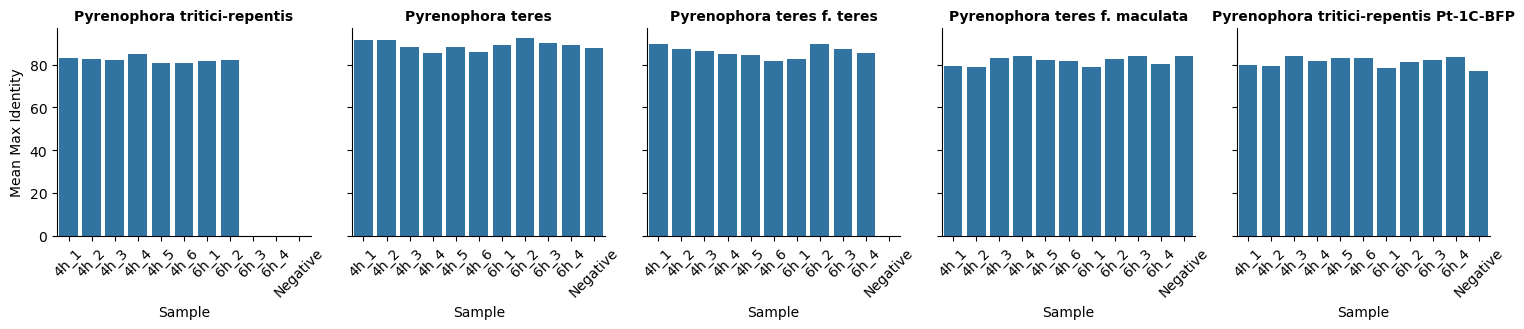

In [12]:
# Create a FacetGrid with the dataframe
g = sns.FacetGrid(data=df,
                col='taxa_name',
                col_wrap=7)

# Map the barplot to each facet
g.map(sns.barplot, 'sample', 'meanMaxIdentity')

# Set x-axis properties for each subplot
g.set_axis_labels("Sample", "Mean Max Identity")
g.set_titles("{col_name}", fontweight = 'heavy', fontsize = 50)  # Set titles based on species

# Set x-axis properties for all subplots
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability


Plot the average meanIdentity

(75.0, 93.78049172336637)

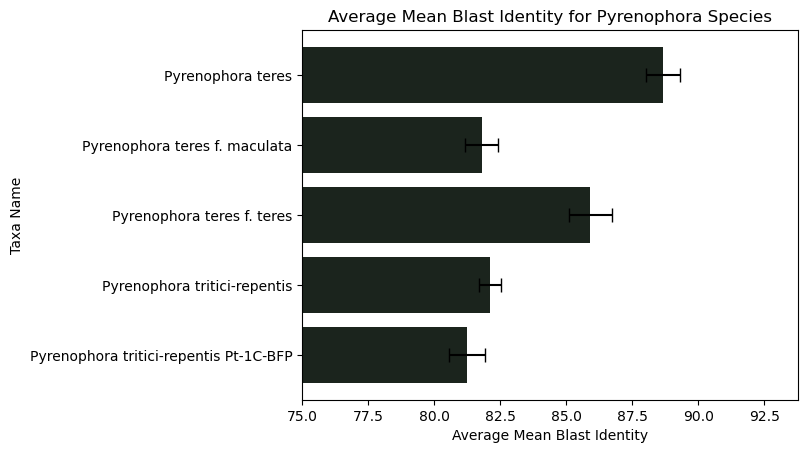

In [16]:
# Group by 'taxa_name' and calculate the mean and standard error of 'meanIdentity'
#change this line depending on my interest
mean_identity_by_taxa = df.groupby('taxa_name')['meanIdentity'].agg(['mean', 'sem']).reset_index()

# Plotting using seaborn
sns.barplot(
    data=mean_identity_by_taxa,
    x='mean',
    y='taxa_name',
    color = "#19261C")
plt.errorbar(x=mean_identity_by_taxa['mean'], y=mean_identity_by_taxa['taxa_name'], xerr=mean_identity_by_taxa['sem'], fmt='none', ecolor='black', capsize=5)
plt.xlabel('Average Mean Blast Identity')
plt.ylabel('Taxa Name')
plt.title('Average Mean Blast Identity for Pyrenophora Species')
plt.xlim(75, None)  # Setting the x-axis limit to start from 75 to allow better visualisation 

In [17]:
mean_identity_by_taxa

,taxa_name,mean,sem
0,Pyrenophora teres,88.672727,0.642027
1,Pyrenophora teres f. maculata,81.800000,0.635610
2,Pyrenophora teres f. teres,85.920000,0.827688
3,Pyrenophora tritici-repentis,82.125000,0.416083
4,Pyrenophora tritici-repentis Pt-1C-BFP,81.254545,0.687468


# Look across all data

Turn whole_dict into one big dataframe

In [16]:
# Convert the dictionary into a list of tuples
data = [(info.taxa_name, info.ncbiRank, info.meanIdentity, info.meanMaxIdentity, info.summedYield, info.ncbiID ,info.sample) for info in whole_dict.values()]

# Convert the list of tuples into a DataFrame
big_data = pd.DataFrame(data, columns=['taxa_name', 'ncbiRank', 'meanIdentity', 'meanMaxIdentity', 'summedYield', 'ncbiID', 'sample'])
big_data[['meanIdentity', 'meanMaxIdentity']] = big_data[['meanIdentity', 'meanMaxIdentity']].astype(float)
big_data[['summedYield']] = big_data[['summedYield']].astype(int)

Plot a graph of the proportion of different ncbiRanks

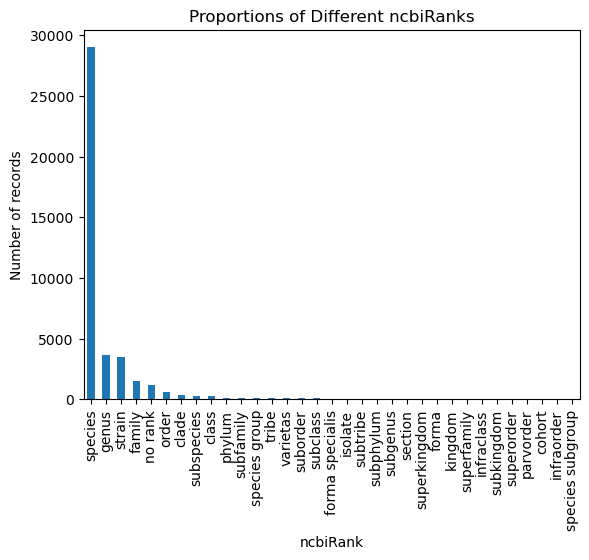

In [17]:
# Calculate the proportions of the different ncbiRanks
proportions = big_data['ncbiRank'].value_counts()

# Plot the proportions
proportions.plot(kind='bar')
plt.ylabel('Number of records')
plt.title('Proportions of Different ncbiRanks')
plt.show()

Looking at spread of mean & max identity by plotting density

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of meanMaxIdentity')

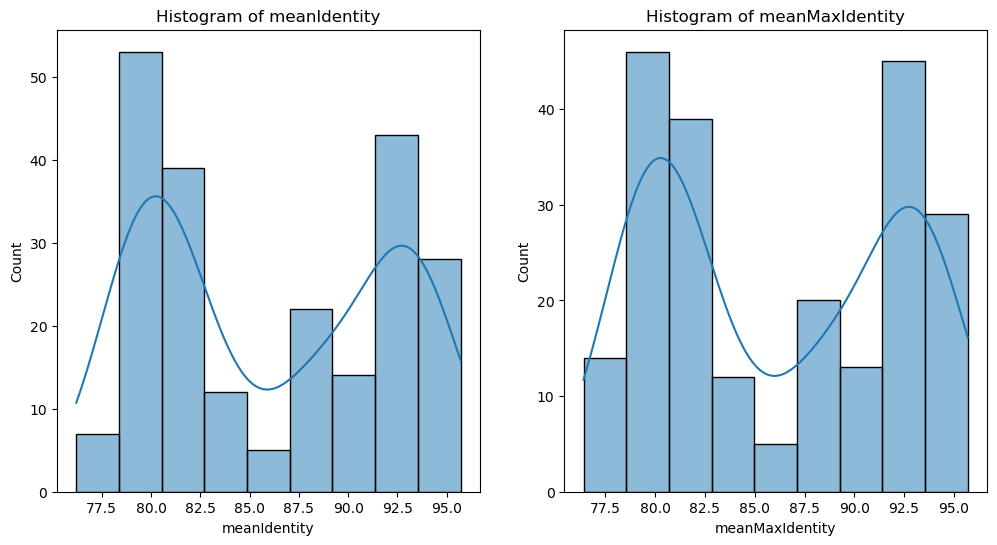

In [18]:
# Histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['meanIdentity'], kde=True)
plt.title('Histogram of meanIdentity')
plt.subplot(1, 2, 2)
sns.histplot(df['meanMaxIdentity'], kde=True)
plt.title('Histogram of meanMaxIdentity')

Looking at taxa with low meanIdentity and high

In [19]:
low_mean_identity = big_data[
   (big_data["meanIdentity"] < 71)
]

high_mean_identity = big_data[
   (big_data["meanIdentity"] > 99)
]

Looking at relationship between summed yield & identity, consider rank

Text(0.5, 1.0, 'Scatter plot of meanIdentity vs summedYield')

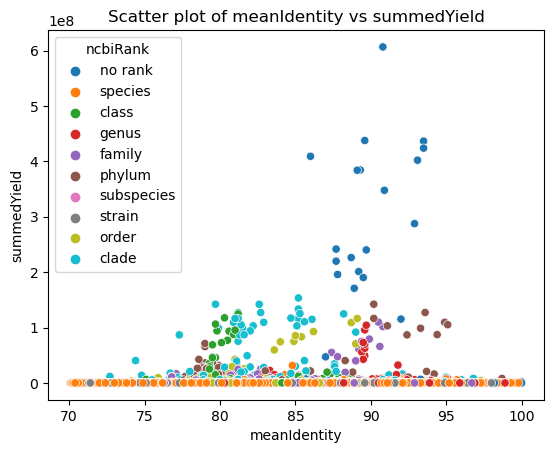

In [20]:
rank_counts = big_data['ncbiRank'].value_counts()
# Filter the DataFrame to include only the rows where 'ncbiRank' appears more than 150 times
filtered_df = big_data[big_data['ncbiRank'].isin(rank_counts[rank_counts > 150].index)]

# Create a scatter plot
sns.scatterplot(
    data = filtered_df,
    x = 'meanIdentity',
    y = 'summedYield',
    hue = 'ncbiRank')
plt.xlabel('meanIdentity')
plt.ylabel('summedYield')
plt.title('Scatter plot of meanIdentity vs summedYield')



Text(0.5, 1.0, 'Scatter plot of meanIdentity vs summedYield')

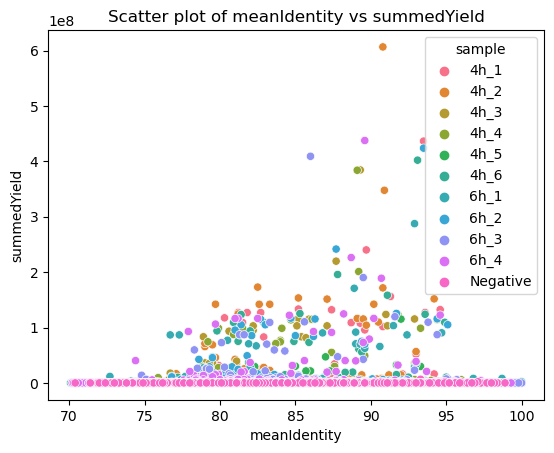

In [21]:
# Create a scatter plot
sns.scatterplot(
    data = big_data,
    x = 'meanIdentity',
    y = 'summedYield',
    hue = 'sample'
    )
plt.xlabel('meanIdentity')
plt.ylabel('summedYield')
plt.title('Scatter plot of meanIdentity vs summedYield')

Text(0.5, 1.0, 'Scatter plot of meanIdentity vs summedYield')

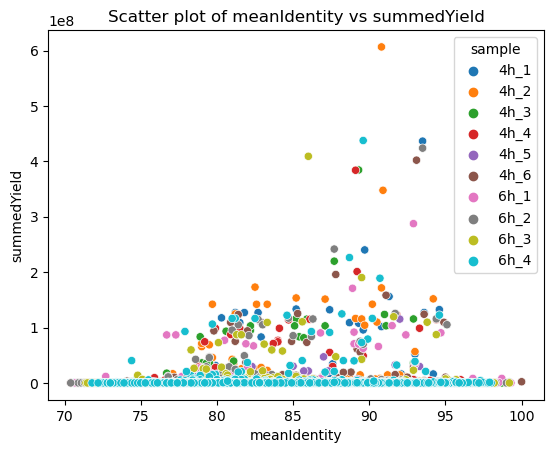

In [22]:
big_data['summedYield'].describe()

#removing the low 50% of summedYield & negative
remove_low_yield = big_data[
    (big_data["summedYield"] > 5.391000e+03) &
    (big_data["sample"] != "Negative")
]


# Create a scatter plot
sns.scatterplot(
    data = remove_low_yield,
    x = 'meanIdentity',
    y = 'summedYield',
    hue = 'sample'
    )
plt.xlabel('meanIdentity')
plt.ylabel('summedYield')
plt.title('Scatter plot of meanIdentity vs summedYield')

Getting the Species with below 71 MeanIdentity to performa literature search

In [23]:
sp_low_mean_identity = big_data[
    (big_data["meanIdentity"] < 71) &
    (big_data["ncbiRank"] == 'species') &
    (big_data["summedYield"] > 3000)
]

#sp_low_mean_identity.to_csv('../sp_low_mean_identity_high_yield.csv')

Just looking at all the streptomyces species from one sample to see how many of them are likely to be real

In [24]:
streptomyces_4h_1 = big_data[
    (big_data["taxa_name"].str.contains('Streptomyces')) &
    (big_data["ncbiRank"] == 'species') &
    (big_data["sample"] == '4h_1')
]

streptomyces_4h_1.to_csv('../streptomyces_4h_1.csv')

In [25]:
pseudomonas = big_data[
    (big_data["taxa_name"].str.contains('Pseudomonas')) &
    (big_data["ncbiRank"] == 'species') &
    (big_data["sample"] == '4h_1')
]

## nonsense taxa

Just looking at 3 samples

Picking out unique species

In [26]:
import pandas as pd
species_samples = big_data[
    (big_data["ncbiRank"] == 'species') &
    (big_data["sample"].isin(['4h_1', '4h_2', '4h_5']))
]
species_samples.set_index('taxa_name', inplace=True)

species_samples = species_samples["ncbiID"]

species_samples.to_csv('../species_4h_1_2_5.csv')


Exported and used taxonkit to get the lineage 

/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/taxonkit.sh

In [27]:
species_lineage = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24hCubTests_21092023/species_4h_1_2_5_taxaID_lineage.csv")

eukaryotes = species_lineage[(species_lineage["kingdom"]=="Eukaryota")]

eukaryotes_genera = eukaryotes["genus"].unique()

eukaryotes_genera

array(['Acrosorium', 'Gymnogongrus', 'Chlamydomonas', 'Auxenochlorella',
       'Chlorella', 'Coccomyxa', 'Stichococcus', 'Desmococcus',
       'Trebouxia', 'Chlorokybus', 'Klebsormidium', 'Marchantia',
       'Schistidium', 'Rhytidiadelphus', 'Nymphaea', 'Spirodela',
       'Posidonia', 'Musa', 'Zingiber', 'Sorghum', 'Tripsacum', 'Zea',
       'Digitaria', 'Setaria', 'Cenchrus', 'Panicum', 'Phyllostachys',
       'Oryza', 'Avena', 'Agrostis', 'Poa', 'Lolium', 'Festuca',
       'x Festulolium', 'Hordeum', 'Secale', 'Aegilops', 'Triticum',
       'Brachypodium', 'Cyperus', 'Ananas', 'Luzula', 'Elaeis', 'Phoenix',
       'Allium', 'Orchis', 'Asparagus', 'Papaver', 'Amaranthus',
       'Agrostemma', 'Polygonum', 'Rumex', 'Rheum', 'Atriplex',
       'Chenopodium', 'Spinacia', 'Beta', 'Ombrophytum', 'Actinidia',
       'Diospyros', 'Impatiens', 'Camellia', 'Daucus', 'Hedera',
       'Triosteum', 'Pulicaria', 'Erigeron', 'Artemisia', 'Chrysanthemum',
       'Opisthopappus', 'Helianthus', 'Ca

In [29]:
np.savetxt('eukaryotes_genera.txt', eukaryotes_genera, delimiter='\t', fmt='%s')

In [33]:
big_data[big_data["taxa_name"] == "Chlamydomonas"]

,taxa_name,ncbiRank,meanIdentity,meanMaxIdentity,summedYield,ncbiID,sample
8243,Chlamydomonas,genus,92.2,93.6,2665,3052,4h_2
